# MNIST

### MNIST 데이터 받기

In [1]:
import os
import sys
from six.moves import urllib
import gzip
import pickle
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt


SOURCE_URL = 'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
FILENAME = SOURCE_URL.split('/')[-1]
DATA_DIR = './datasets'

def maybe_download(data_dir):
    filepath = os.path.join(data_dir, FILENAME)
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    if not os.path.isfile(filepath):
        def _progress(count, block_size, total_size):
            sys.stdout.write('\r>> Downloading {} {:.1f} %'.format(
                FILENAME, float(count * block_size) / float(total_size) * 100.0))
            sys.stdout.flush()
        filepath, _ = urllib.request.urlretrieve(SOURCE_URL, filepath, _progress)
        print()
        statinfo = os.stat(filepath)
        print('Successfully donloaded', FILENAME, statinfo.st_size, 'bytes.')

def load(data_dir, subset='train'):
    maybe_download(data_dir)
    filepath = os.path.join(data_dir, FILENAME)
    
    f = gzip.open(filepath, 'rb')
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    train_set, valid_set, test_set = u.load()
    f.close()
    
    if subset == 'train':
        trainx, trainy = train_set
        trainx = trainx.astype(np.float32).reshape(trainx.shape[0], 28, 28)
        trainy = trainy.astype(np.uint8)
        return trainx, trainy
    elif subset == 'test':
        testx, testy = test_set
        testx = testx.astype(np.float32).reshape(testx.shape[0], 28, 28)
        testy = testy.astype(np.uint8)
        return testx, testy
    elif subset== 'valid':
        validx, validy = valid_set
        validx = validx.astype(np.float32).reshape(validx.shape[0], 28, 28)
        validy = validy.astype(np.uint8)
        return validx, validy
    else:
        raise NotImplementedError('subset should be train or valid or test')

# Load data
train_data, train_label = load(DATA_DIR, 'train')
valid_data, valid_label = load(DATA_DIR, 'valid')
test_data, test_label = load(DATA_DIR, 'test')

# concatenate train and valid data as train data
train_data = np.concatenate((train_data, valid_data))
train_label = np.concatenate((train_label, valid_label))

>> Downloading mnist.pkl.gz 100.0 %
Successfully donloaded mnist.pkl.gz 16168813 bytes.


### MNIST 데이터 확인 하기

In [2]:
# size of MNIST
print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


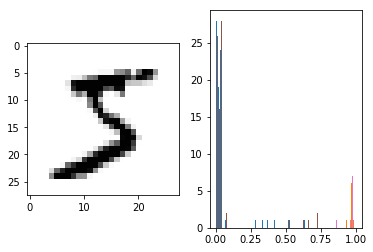

In [3]:
# show data
_, (ax1, ax2) = plt.subplots(1, 2)
sample_data = train_data[0]
ax1.imshow(sample_data, cmap=plt.cm.Greys);
ax2.hist(sample_data, bins=20, range=[0, 1]);